# Task 1.1 - Modal → Amodal Mask Prediction Baseline

In [3]:
!tar -xvzf "ff5da6d6ecae486bb294aeaf5ee8f8a1 (3).tar.gz" -C /content

ff5da6d6ecae486bb294aeaf5ee8f8a1/
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0005/
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0005/obj_0018/
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0005/obj_0018/depth_00008.tiff
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0005/obj_0018/segmentation_00019.png
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0005/obj_0018/depth_00021.tiff
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0005/obj_0018/rgba_00002.png
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0005/obj_0018/segmentation_00017.png
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0005/obj_0018/segmentation_00010.png
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0005/obj_0018/rgba_00005.png
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0005/obj_0018/depth_00010.tiff
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0005/obj_0018/segmentation_00022.png
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0005/obj_0018/depth_00014.tiff
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0005/obj_0018/events.json
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0005/obj_0018/depth_00018.tif

In [8]:
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm

# ✅ Robust dataset: matches rgba and segmentation by frame index
class RGBAtoSegmentationDataset(Dataset):
    def __init__(self, root_path):
        self.rgb_paths = []
        self.seg_paths = []

        for obj_folder in root_path.rglob("obj_*"):
            rgba_files = sorted(obj_folder.glob("rgba_*.png"))
            seg_files = sorted(obj_folder.glob("segmentation_*.png"))

            rgba_dict = {f.stem.split("_")[1]: f for f in rgba_files}
            seg_dict = {f.stem.split("_")[1]: f for f in seg_files}

            matched_keys = sorted(set(rgba_dict.keys()) & set(seg_dict.keys()))

            for key in matched_keys:
                self.rgb_paths.append(rgba_dict[key])
                self.seg_paths.append(seg_dict[key])

        assert len(self.rgb_paths) > 0, "No matched rgba-segmentation pairs found."

        self.transform_img = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        self.transform_mask = transforms.Resize((256, 256))

    def __len__(self):
        return len(self.rgb_paths)

    def __getitem__(self, idx):
        rgba = Image.open(self.rgb_paths[idx]).convert("RGB")
        seg = Image.open(self.seg_paths[idx]).convert("L")

        rgba = self.transform_img(rgba)
        seg = self.transform_mask(seg)
        seg = torch.from_numpy(np.array(seg)).long()
        seg[seg > 0] = 1

        return rgba, seg

# ✅ U-Net model
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=2):
        super(UNet, self).__init__()
        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        self.enc1 = nn.Sequential(CBR(in_channels, 64), CBR(64, 64))
        self.enc2 = nn.Sequential(CBR(64, 128), CBR(128, 128))
        self.enc3 = nn.Sequential(CBR(128, 256), CBR(256, 256))
        self.pool = nn.MaxPool2d(2)
        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = nn.Sequential(CBR(256, 128), CBR(128, 128))
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = nn.Sequential(CBR(128, 64), CBR(64, 64))
        self.out = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        d1 = self.up1(e3)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)
        d2 = self.up2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)
        return self.out(d2)

# ✅ IoU metric
def compute_iou(pred_mask, true_mask):
    pred_mask = torch.argmax(pred_mask, dim=1)
    intersection = ((pred_mask == true_mask) & (true_mask > 0)).sum().float()
    union = ((pred_mask > 0) | (true_mask > 0)).sum().float()
    return (intersection + 1e-6) / (union + 1e-6)

# ✅ Training function
def train_model(model, dataloader, device, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        total_iou = 0.0
        for img, mask in tqdm(dataloader):
            img, mask = img.to(device), mask.to(device)
            optimizer.zero_grad()
            out = model(img)
            loss = criterion(out, mask)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_iou += compute_iou(out, mask).item()
        print(f"Epoch {epoch+1}: Loss = {total_loss/len(dataloader):.4f}, IoU = {total_iou/len(dataloader):.4f}")

# ✅ Set path and run training
root_path = Path("/content/ff5da6d6ecae486bb294aeaf5ee8f8a1")
dataset = RGBAtoSegmentationDataset(root_path)

print("Loaded samples:", len(dataset))
print("First image:", dataset.rgb_paths[0].name)
print("First mask :", dataset.seg_paths[0].name)

loader = DataLoader(dataset, batch_size=2, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=2).to(device)

train_model(model, loader, device, epochs=5)



Loaded samples: 1272
First image: rgba_00000.png
First mask : segmentation_00000.png


100%|██████████| 636/636 [00:52<00:00, 12.12it/s]


Epoch 1: Loss = 0.0247, IoU = 0.9516


100%|██████████| 636/636 [00:51<00:00, 12.27it/s]


Epoch 2: Loss = 0.0011, IoU = 0.9838


100%|██████████| 636/636 [00:51<00:00, 12.31it/s]


Epoch 3: Loss = 0.0007, IoU = 0.9850


100%|██████████| 636/636 [00:51<00:00, 12.32it/s]


Epoch 4: Loss = 0.0023, IoU = 0.9654


100%|██████████| 636/636 [00:51<00:00, 12.33it/s]

Epoch 5: Loss = 0.0007, IoU = 0.9813


Train size: 1017, Test size: 255


100%|██████████| 509/509 [00:44<00:00, 11.50it/s]


Epoch 1: Loss = 0.0491, IoU = 0.9491


100%|██████████| 509/509 [00:40<00:00, 12.50it/s]


Epoch 2: Loss = 0.0053, IoU = 0.9546


100%|██████████| 509/509 [00:41<00:00, 12.33it/s]


Epoch 3: Loss = 0.0014, IoU = 0.9770


100%|██████████| 509/509 [00:41<00:00, 12.38it/s]


Epoch 4: Loss = 0.0009, IoU = 0.9828


100%|██████████| 509/509 [00:41<00:00, 12.34it/s]


Epoch 5: Loss = 0.0007, IoU = 0.9845


100%|██████████| 128/128 [00:03<00:00, 33.41it/s]


Test IoU = 0.9879


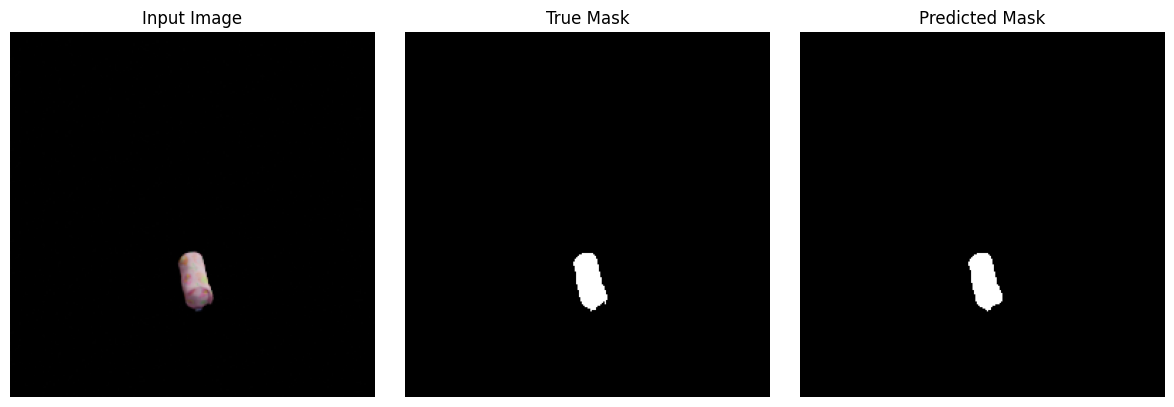

In [9]:
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Dataset class with safe pair matching
class RGBAtoSegmentationDataset(Dataset):
    def __init__(self, root_path):
        self.rgb_paths = []
        self.seg_paths = []

        for obj_folder in root_path.rglob("obj_*"):
            rgba_files = sorted(obj_folder.glob("rgba_*.png"))
            seg_files = sorted(obj_folder.glob("segmentation_*.png"))

            rgba_dict = {f.stem.split("_")[1]: f for f in rgba_files}
            seg_dict = {f.stem.split("_")[1]: f for f in seg_files}

            matched_keys = sorted(set(rgba_dict.keys()) & set(seg_dict.keys()))
            for key in matched_keys:
                self.rgb_paths.append(rgba_dict[key])
                self.seg_paths.append(seg_dict[key])

        assert len(self.rgb_paths) > 0, "No matched rgba-segmentation pairs found."

        self.transform_img = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        self.transform_mask = transforms.Resize((256, 256))

    def __len__(self):
        return len(self.rgb_paths)

    def __getitem__(self, idx):
        rgba = Image.open(self.rgb_paths[idx]).convert("RGB")
        seg = Image.open(self.seg_paths[idx]).convert("L")

        rgba = self.transform_img(rgba)
        seg = self.transform_mask(seg)
        seg = torch.from_numpy(np.array(seg)).long()
        seg[seg > 0] = 1
        return rgba, seg

# U-Net
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=2):
        super(UNet, self).__init__()
        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        self.enc1 = nn.Sequential(CBR(in_channels, 64), CBR(64, 64))
        self.enc2 = nn.Sequential(CBR(64, 128), CBR(128, 128))
        self.enc3 = nn.Sequential(CBR(128, 256), CBR(256, 256))
        self.pool = nn.MaxPool2d(2)
        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = nn.Sequential(CBR(256, 128), CBR(128, 128))
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = nn.Sequential(CBR(128, 64), CBR(64, 64))
        self.out = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        d1 = self.up1(e3)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)
        d2 = self.up2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)
        return self.out(d2)

# IoU
def compute_iou(pred_mask, true_mask):
    pred_mask = torch.argmax(pred_mask, dim=1)
    intersection = ((pred_mask == true_mask) & (true_mask > 0)).sum().float()
    union = ((pred_mask > 0) | (true_mask > 0)).sum().float()
    return (intersection + 1e-6) / (union + 1e-6)

# Training
def train_model(model, dataloader, device, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        total_iou = 0.0
        for img, mask in tqdm(dataloader):
            img, mask = img.to(device), mask.to(device)
            optimizer.zero_grad()
            out = model(img)
            loss = criterion(out, mask)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_iou += compute_iou(out, mask).item()
        print(f"Epoch {epoch+1}: Loss = {total_loss/len(dataloader):.4f}, IoU = {total_iou/len(dataloader):.4f}")

# Evaluation
def evaluate_model(model, dataloader, device):
    model.eval()
    total_iou = 0.0
    with torch.no_grad():
        for img, mask in tqdm(dataloader):
            img, mask = img.to(device), mask.to(device)
            out = model(img)
            total_iou += compute_iou(out, mask).item()
    print(f"Test IoU = {total_iou / len(dataloader):.4f}")

# Optional: Visualize sample prediction
def visualize_prediction(model, dataset, device, idx=0):
    model.eval()
    img, true_mask = dataset[idx]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred_mask = torch.argmax(pred.squeeze(), dim=0).cpu().numpy()
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img.permute(1, 2, 0))
    axs[0].set_title("Input Image")
    axs[1].imshow(true_mask, cmap="gray")
    axs[1].set_title("True Mask")
    axs[2].imshow(pred_mask, cmap="gray")
    axs[2].set_title("Predicted Mask")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Main script
root_path = Path("/content/ff5da6d6ecae486bb294aeaf5ee8f8a1")
dataset = RGBAtoSegmentationDataset(root_path)

# Split into train/test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

print(f"Train size: {len(train_set)}, Test size: {len(test_set)}")

train_loader = DataLoader(train_set, batch_size=2, shuffle=True)
test_loader = DataLoader(test_set, batch_size=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=2).to(device)

# Train and evaluate
train_model(model, train_loader, device, epochs=5)
evaluate_model(model, test_loader, device)

# Visualize prediction from test set
visualize_prediction(model, test_set, device, idx=0)


Found 54 object folders.


Evaluating middle frames:   0%|          | 0/54 [00:00<?, ?it/s]

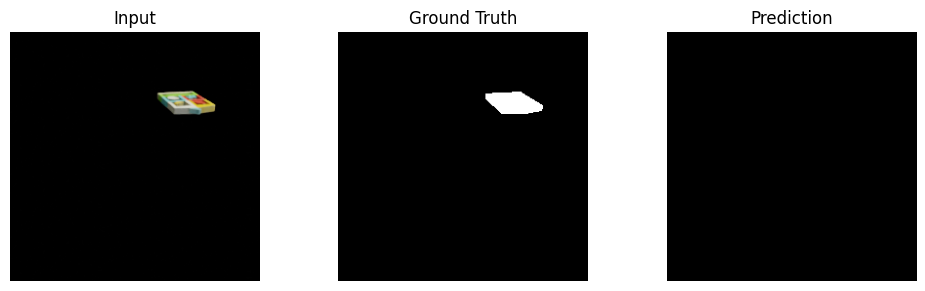

Evaluating middle frames:   2%|▏         | 1/54 [00:00<00:10,  5.26it/s]

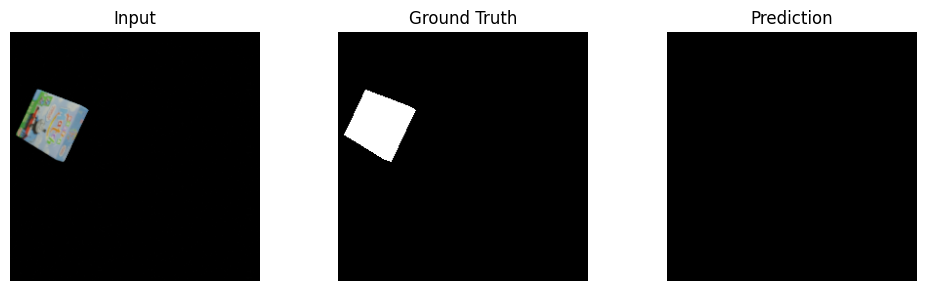

Evaluating middle frames:   4%|▎         | 2/54 [00:00<00:09,  5.31it/s]

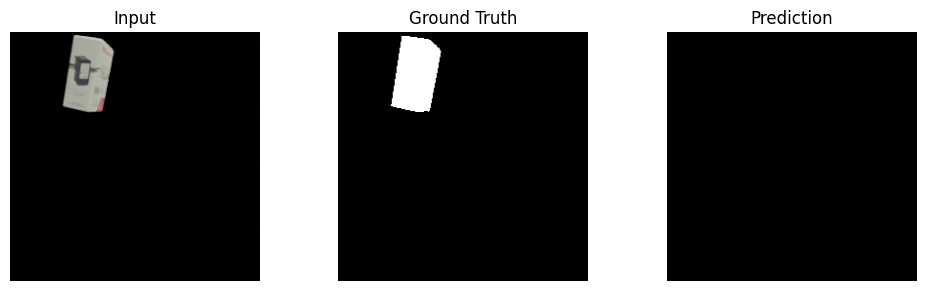

Evaluating middle frames:   6%|▌         | 3/54 [00:00<00:09,  5.19it/s]

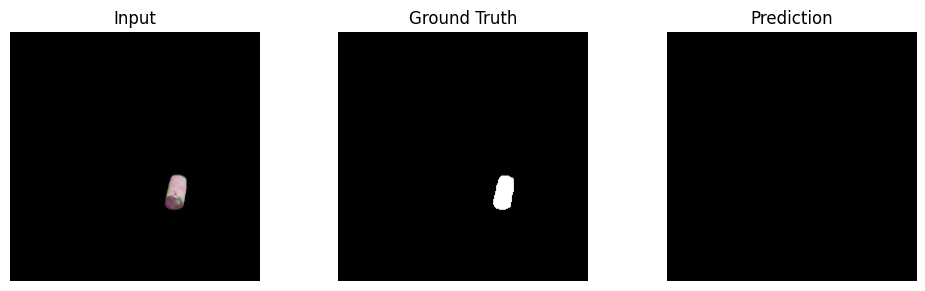

Evaluating middle frames:   7%|▋         | 4/54 [00:00<00:09,  5.26it/s]

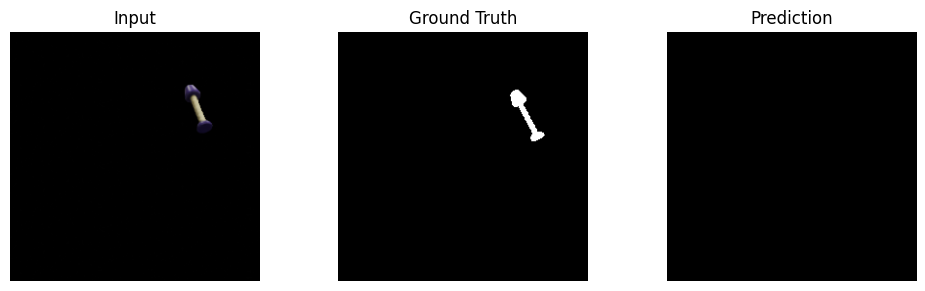

Evaluating middle frames:   9%|▉         | 5/54 [00:00<00:09,  5.13it/s]

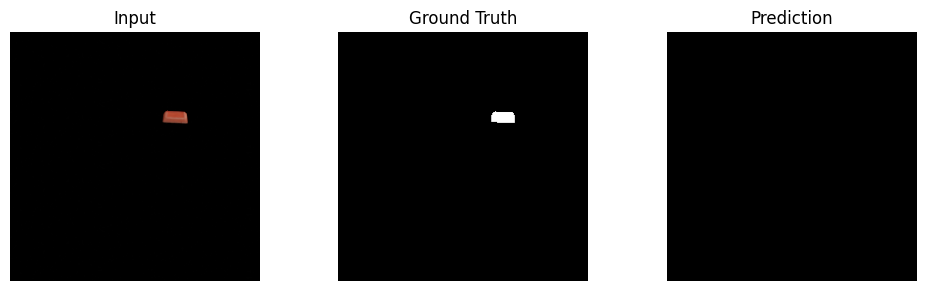

Evaluating middle frames:  11%|█         | 6/54 [00:01<00:11,  4.25it/s]

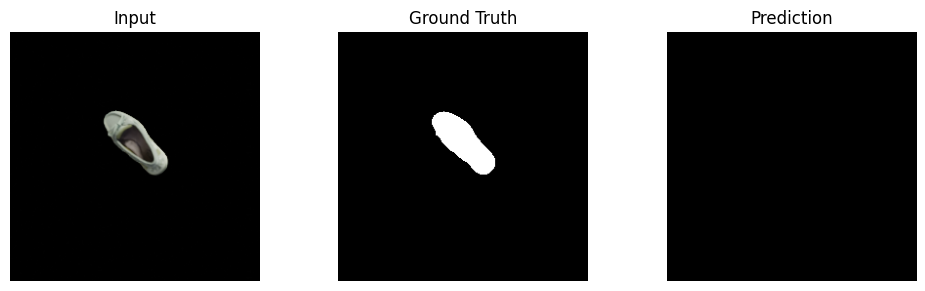

Evaluating middle frames:  13%|█▎        | 7/54 [00:01<00:11,  4.03it/s]

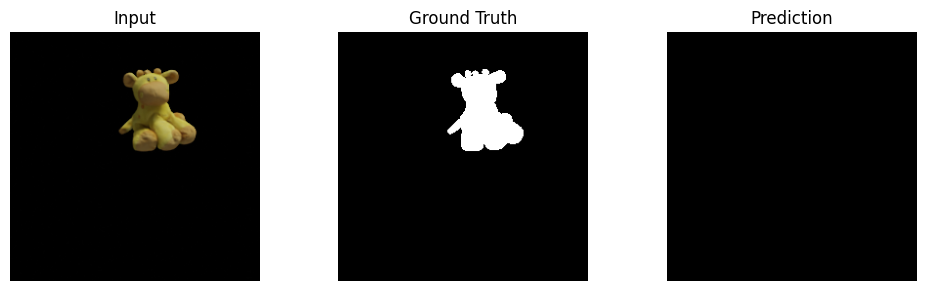

Evaluating middle frames:  15%|█▍        | 8/54 [00:01<00:11,  3.88it/s]

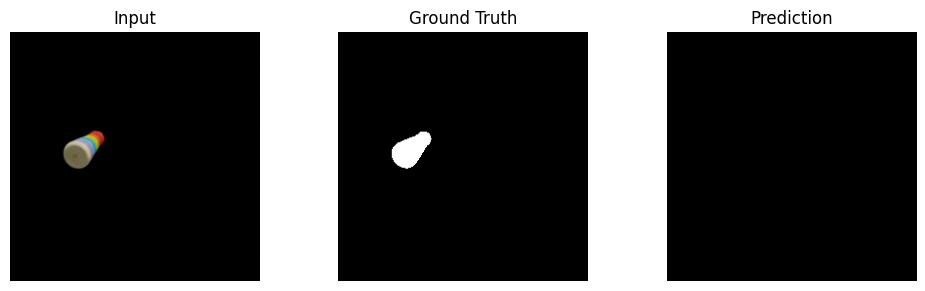

Evaluating middle frames:  17%|█▋        | 9/54 [00:02<00:17,  2.58it/s]

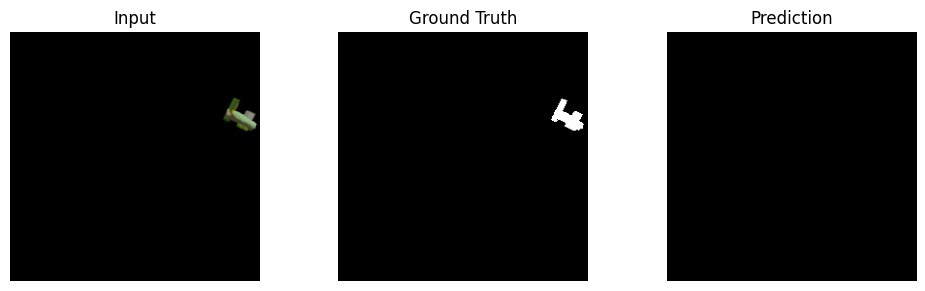

Evaluating middle frames:  19%|█▊        | 10/54 [00:03<00:21,  2.01it/s]

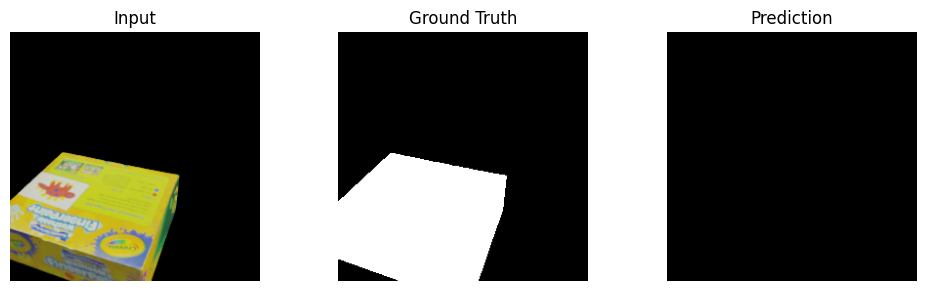

Evaluating middle frames:  20%|██        | 11/54 [00:04<00:30,  1.40it/s]

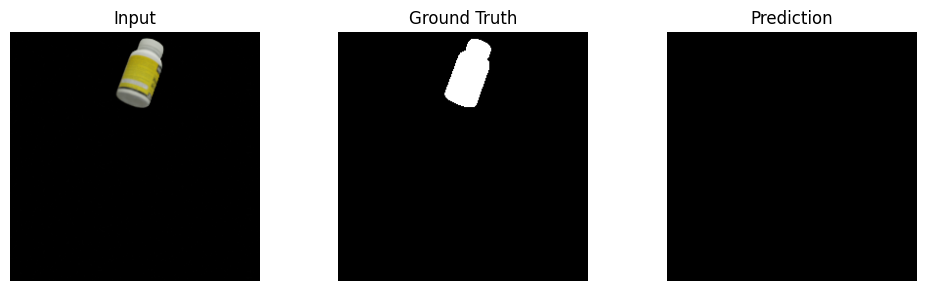

Evaluating middle frames:  22%|██▏       | 12/54 [00:04<00:23,  1.81it/s]

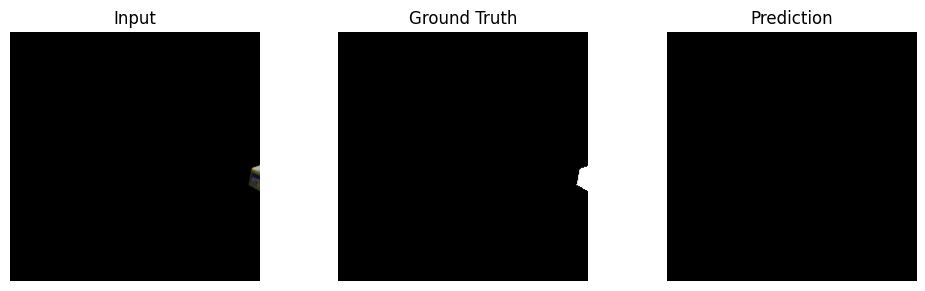

Evaluating middle frames:  24%|██▍       | 13/54 [00:04<00:18,  2.25it/s]

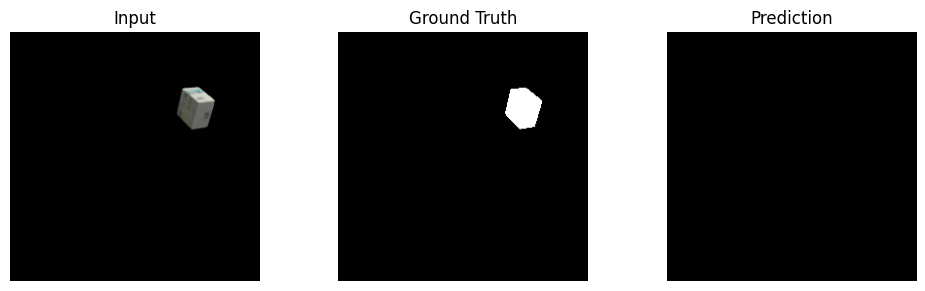

Evaluating middle frames:  26%|██▌       | 14/54 [00:05<00:14,  2.73it/s]

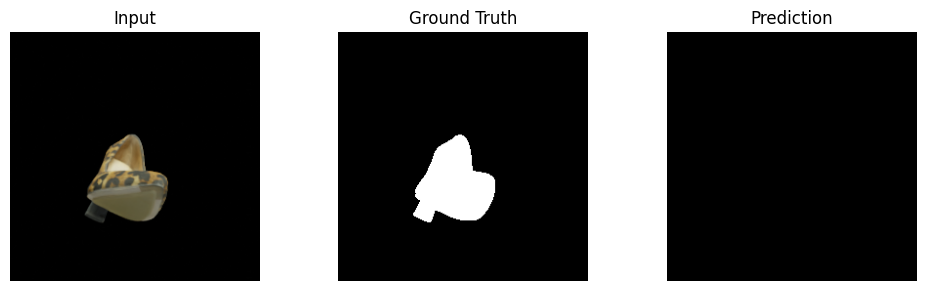

Evaluating middle frames:  28%|██▊       | 15/54 [00:05<00:12,  3.14it/s]

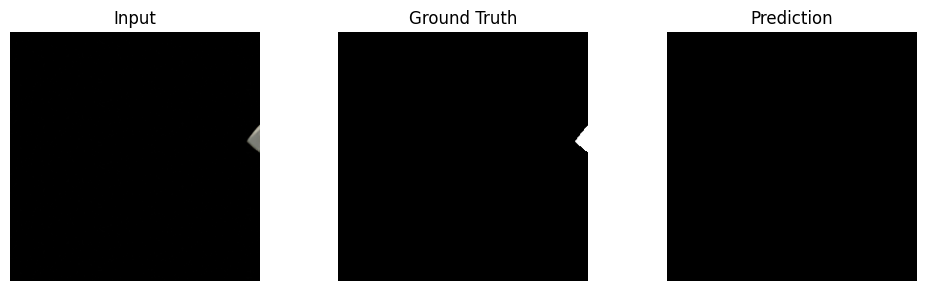

Evaluating middle frames:  30%|██▉       | 16/54 [00:05<00:10,  3.54it/s]

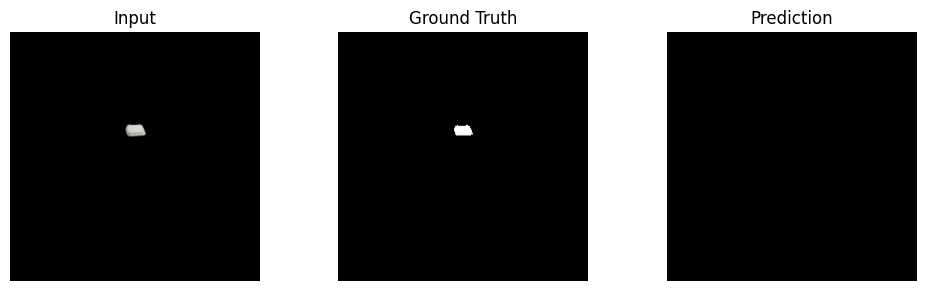

Evaluating middle frames:  31%|███▏      | 17/54 [00:05<00:09,  3.93it/s]

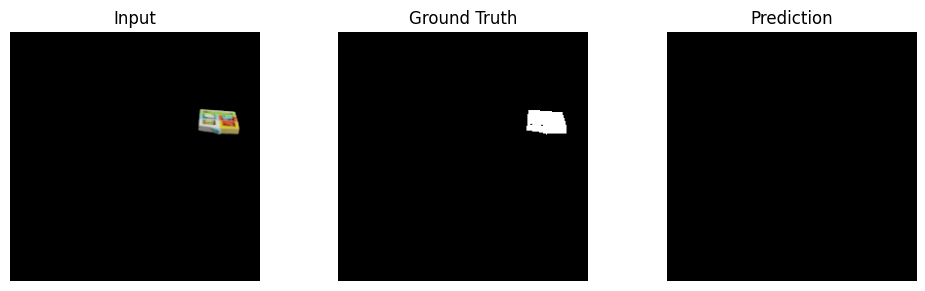

Evaluating middle frames:  33%|███▎      | 18/54 [00:05<00:08,  4.24it/s]

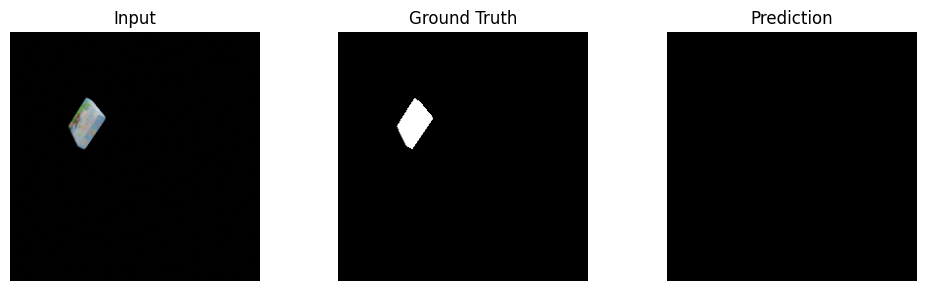

Evaluating middle frames:  35%|███▌      | 19/54 [00:05<00:07,  4.50it/s]

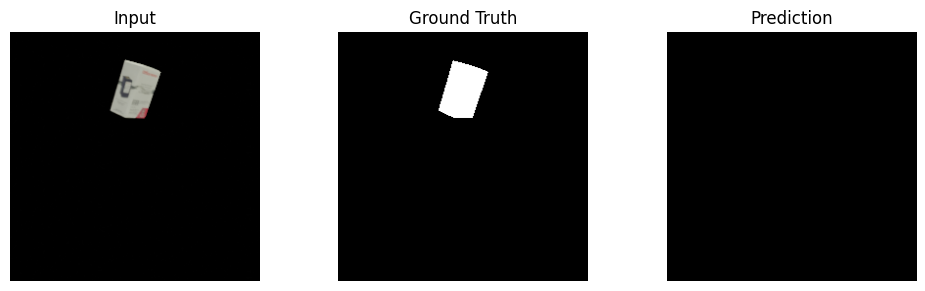

Evaluating middle frames:  37%|███▋      | 20/54 [00:06<00:07,  4.45it/s]

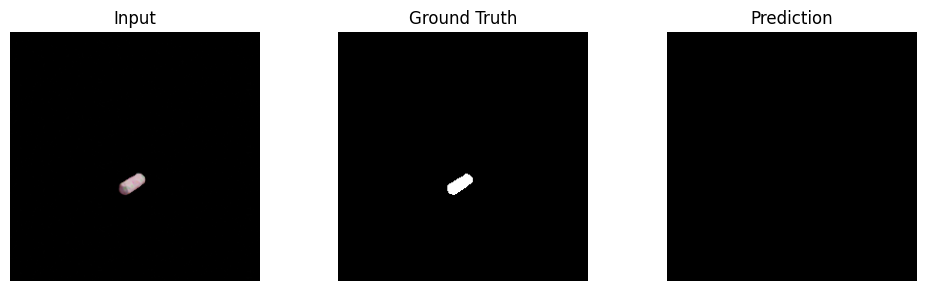

Evaluating middle frames:  39%|███▉      | 21/54 [00:06<00:07,  4.62it/s]

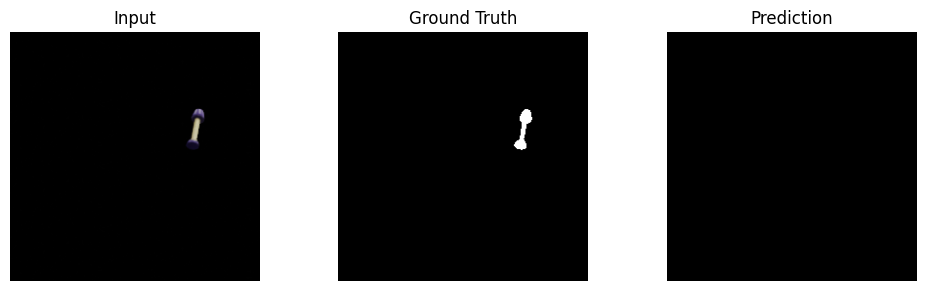

Evaluating middle frames:  41%|████      | 22/54 [00:06<00:06,  4.85it/s]

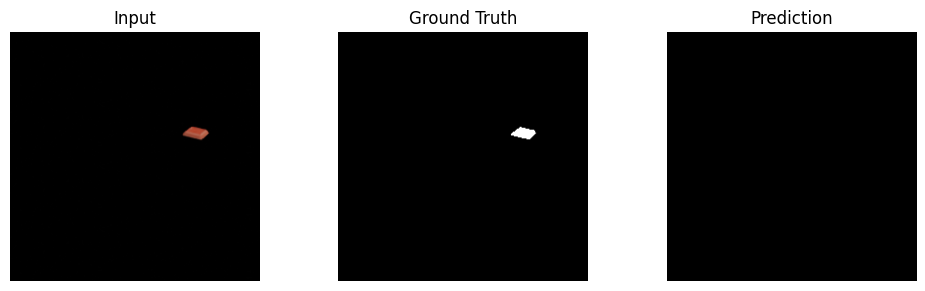

Evaluating middle frames:  43%|████▎     | 23/54 [00:06<00:06,  4.99it/s]

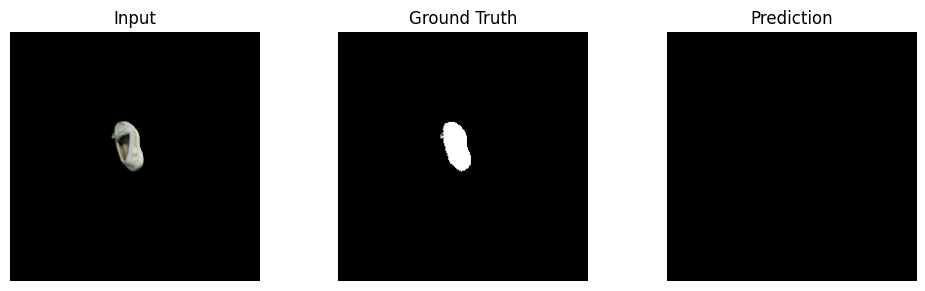

Evaluating middle frames:  44%|████▍     | 24/54 [00:06<00:05,  5.09it/s]

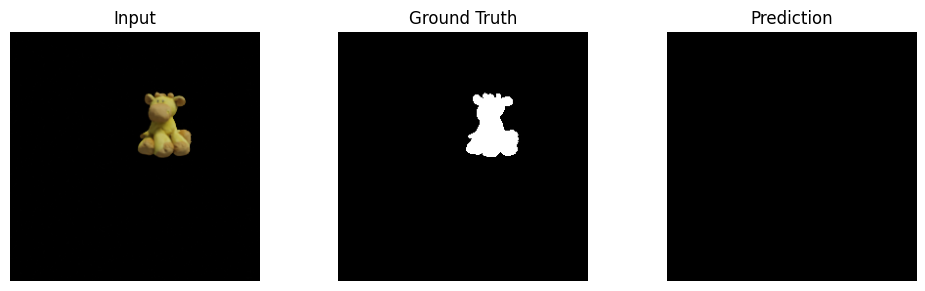

Evaluating middle frames:  46%|████▋     | 25/54 [00:07<00:07,  3.96it/s]

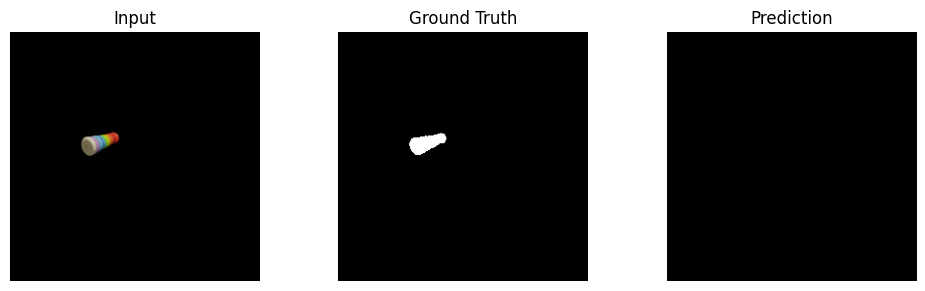

Evaluating middle frames:  48%|████▊     | 26/54 [00:07<00:06,  4.32it/s]

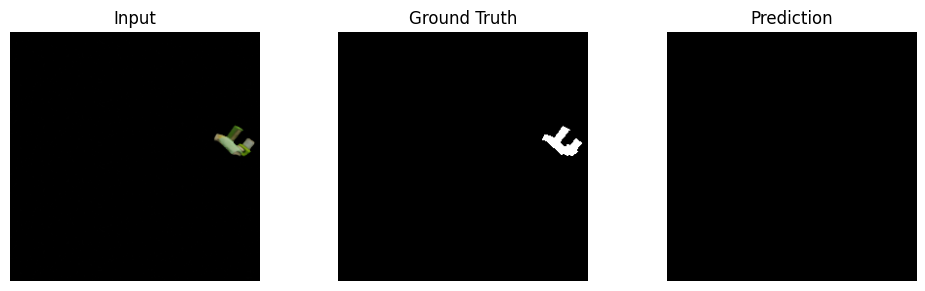

Evaluating middle frames:  50%|█████     | 27/54 [00:07<00:06,  4.46it/s]

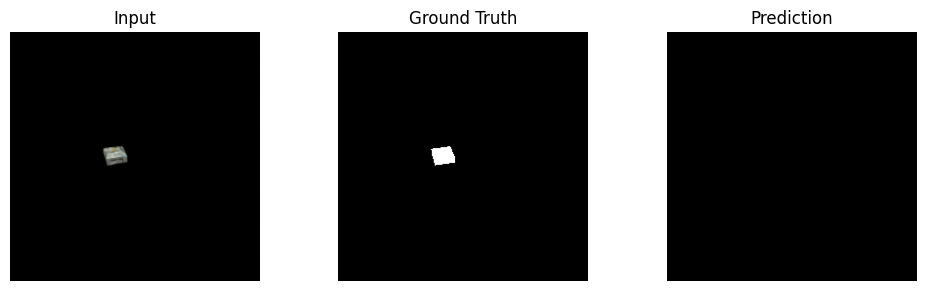

Evaluating middle frames:  52%|█████▏    | 28/54 [00:07<00:05,  4.66it/s]

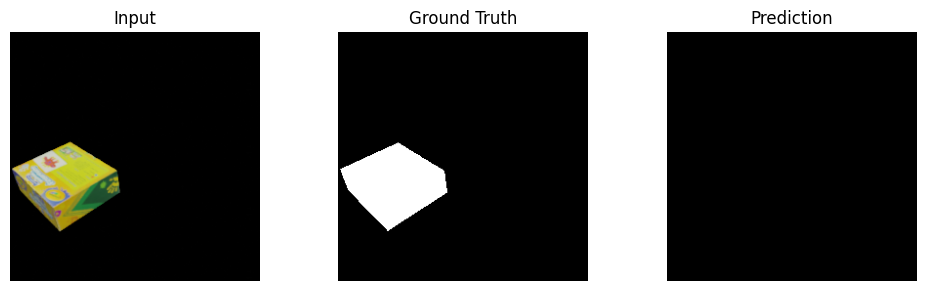

Evaluating middle frames:  54%|█████▎    | 29/54 [00:08<00:05,  4.77it/s]

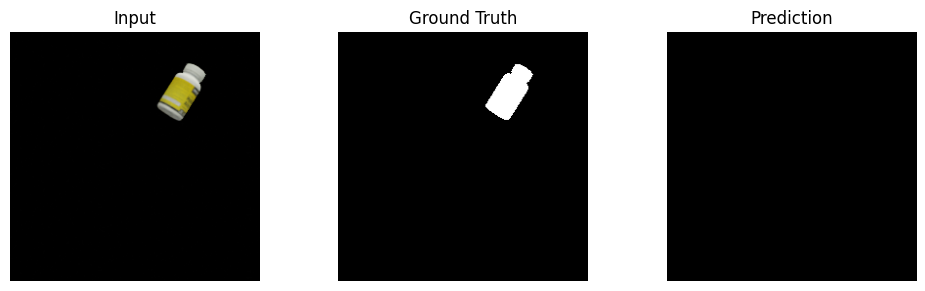

Evaluating middle frames:  56%|█████▌    | 30/54 [00:08<00:04,  4.88it/s]

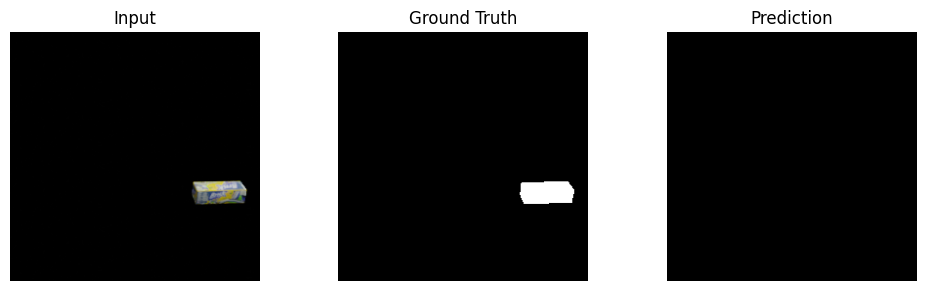

Evaluating middle frames:  57%|█████▋    | 31/54 [00:08<00:04,  5.07it/s]

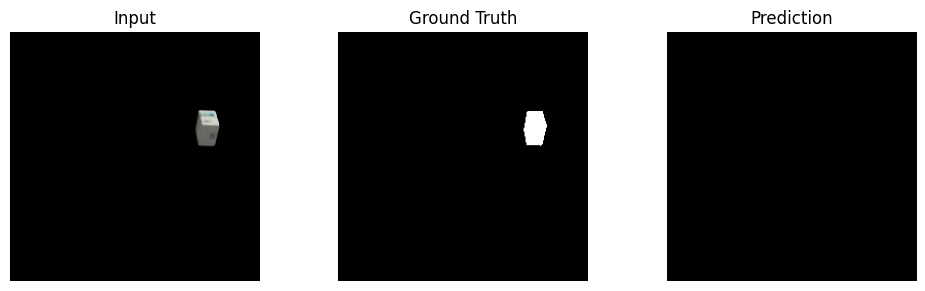

Evaluating middle frames:  59%|█████▉    | 32/54 [00:08<00:04,  5.03it/s]

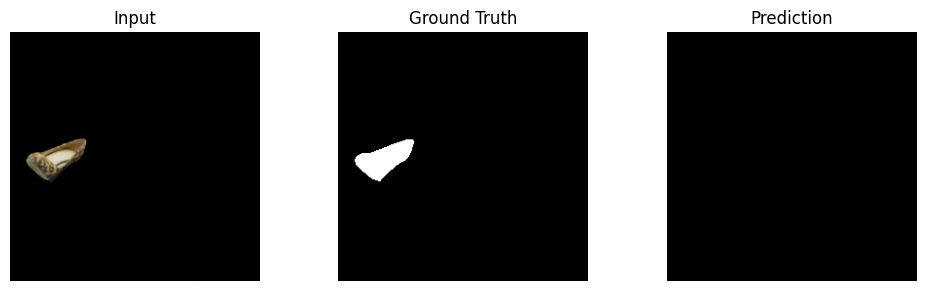

Evaluating middle frames:  61%|██████    | 33/54 [00:08<00:04,  5.11it/s]

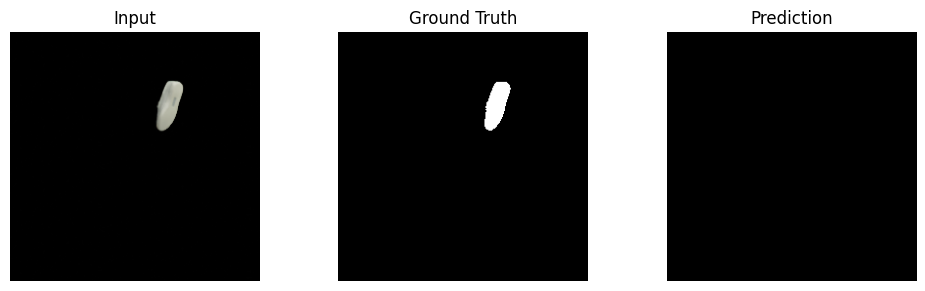

Evaluating middle frames:  63%|██████▎   | 34/54 [00:09<00:03,  5.11it/s]

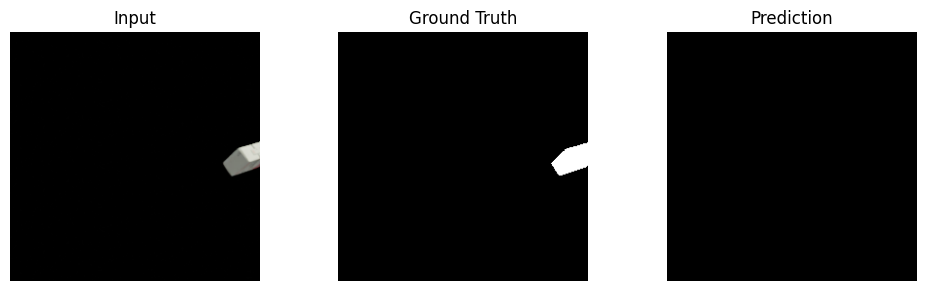

Evaluating middle frames:  65%|██████▍   | 35/54 [00:09<00:03,  5.10it/s]

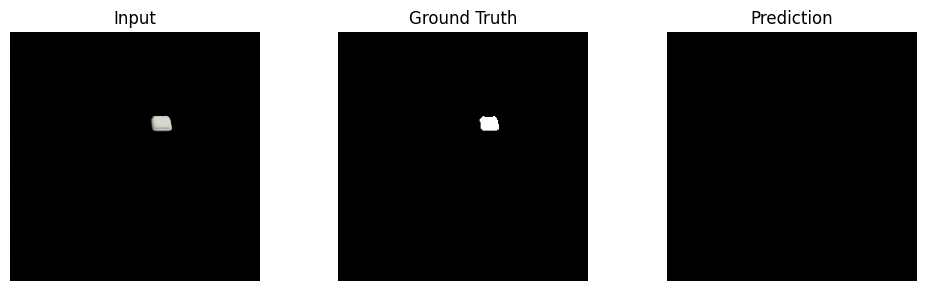

Evaluating middle frames:  67%|██████▋   | 36/54 [00:09<00:03,  5.15it/s]

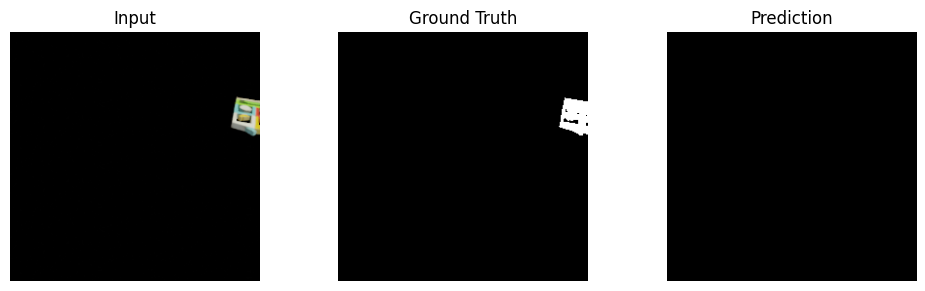

Evaluating middle frames:  69%|██████▊   | 37/54 [00:09<00:03,  5.17it/s]

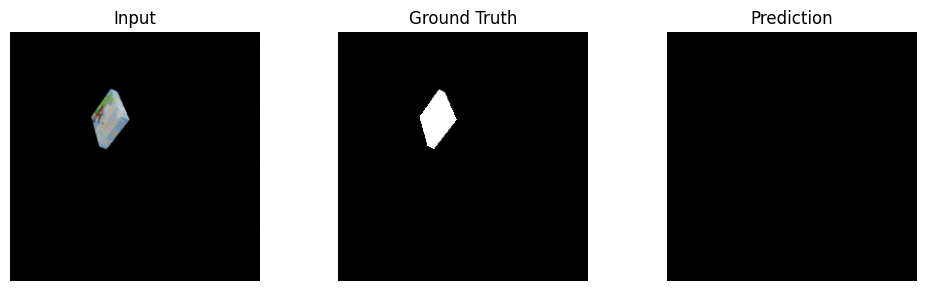

Evaluating middle frames:  70%|███████   | 38/54 [00:09<00:03,  5.08it/s]

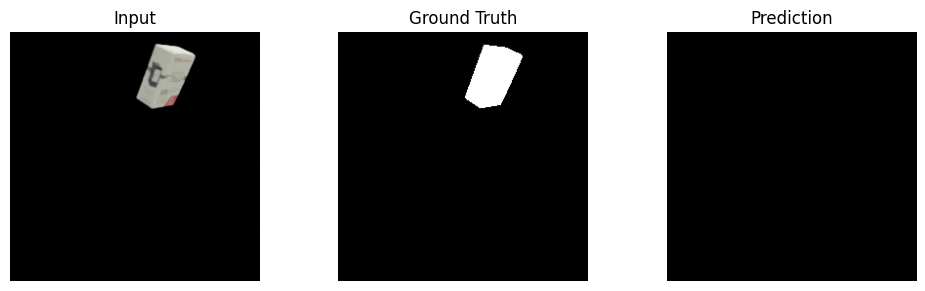

Evaluating middle frames:  72%|███████▏  | 39/54 [00:10<00:04,  3.73it/s]

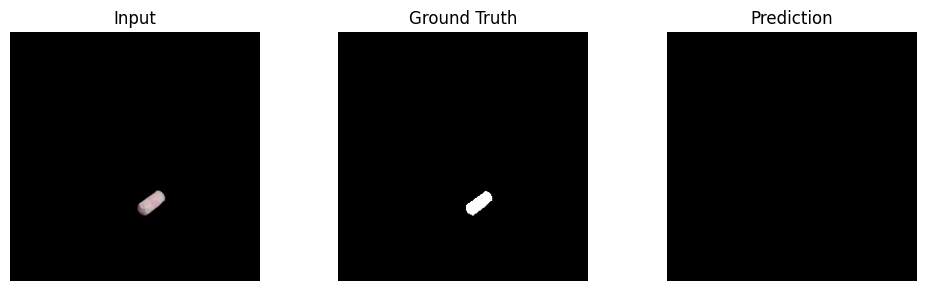

Evaluating middle frames:  74%|███████▍  | 40/54 [00:10<00:03,  4.11it/s]

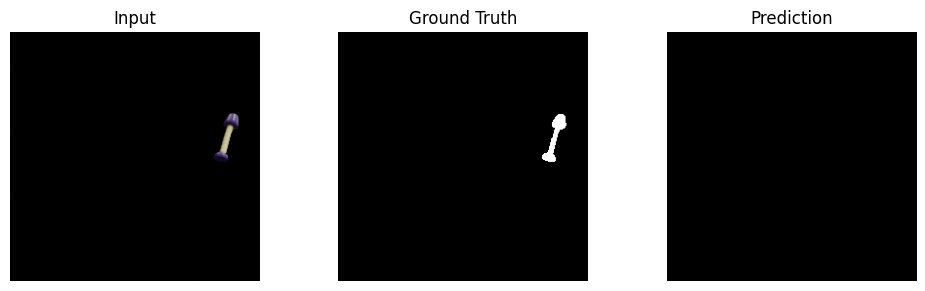

Evaluating middle frames:  76%|███████▌  | 41/54 [00:10<00:02,  4.42it/s]

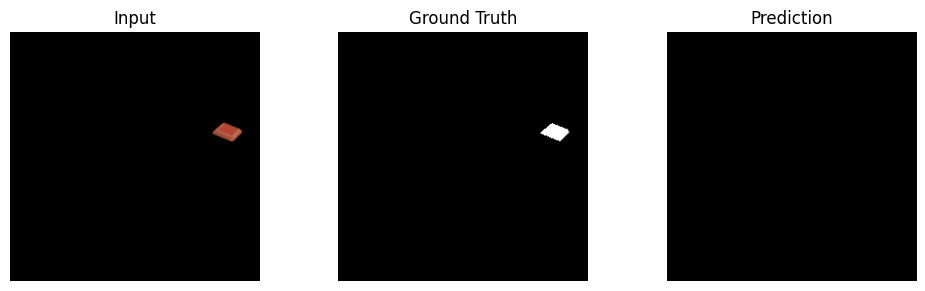

Evaluating middle frames:  78%|███████▊  | 42/54 [00:10<00:02,  4.49it/s]

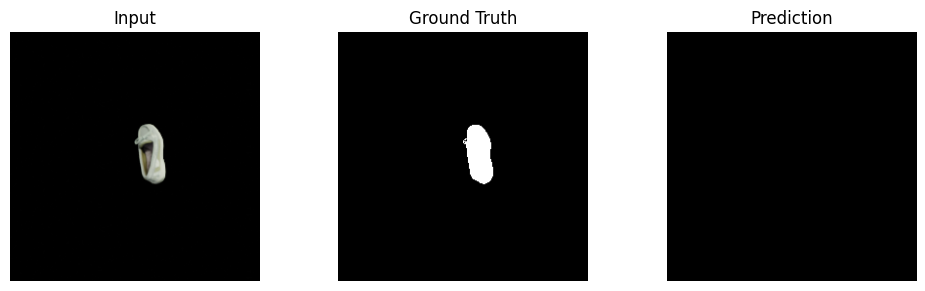

Evaluating middle frames:  80%|███████▉  | 43/54 [00:11<00:02,  4.78it/s]

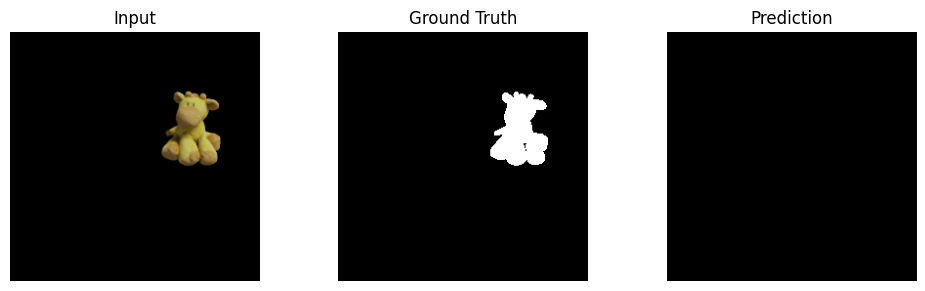

Evaluating middle frames:  81%|████████▏ | 44/54 [00:11<00:02,  4.87it/s]

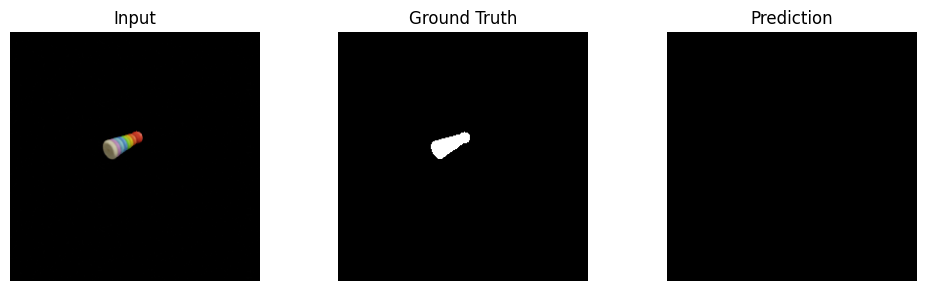

Evaluating middle frames:  83%|████████▎ | 45/54 [00:11<00:01,  4.79it/s]

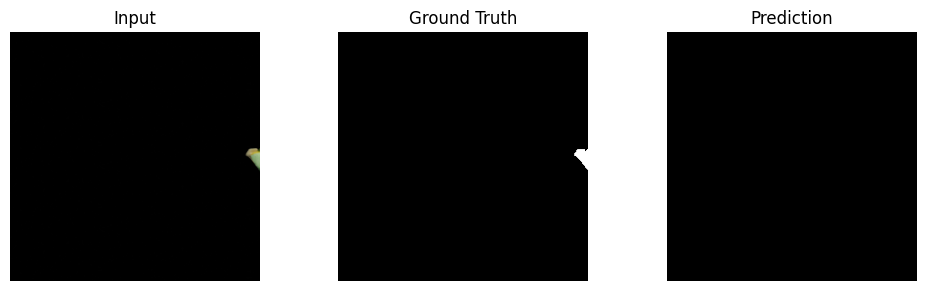

Evaluating middle frames:  85%|████████▌ | 46/54 [00:11<00:01,  4.89it/s]

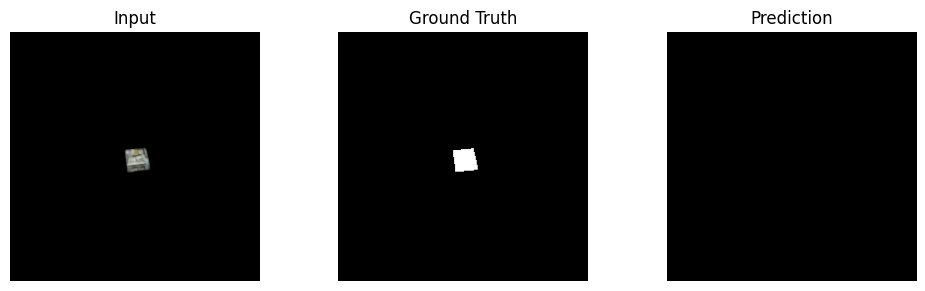

Evaluating middle frames:  87%|████████▋ | 47/54 [00:11<00:01,  4.90it/s]

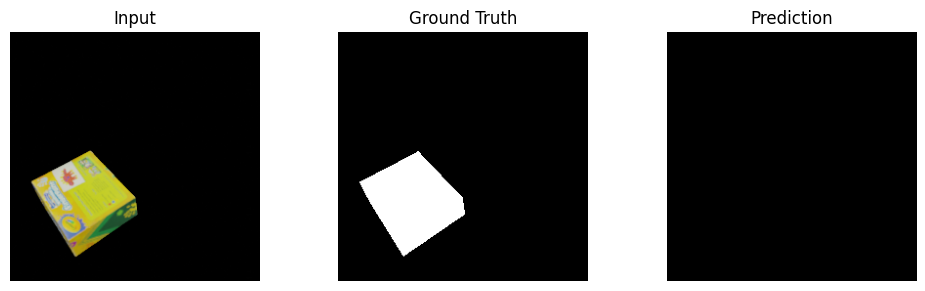

Evaluating middle frames:  89%|████████▉ | 48/54 [00:12<00:01,  4.85it/s]

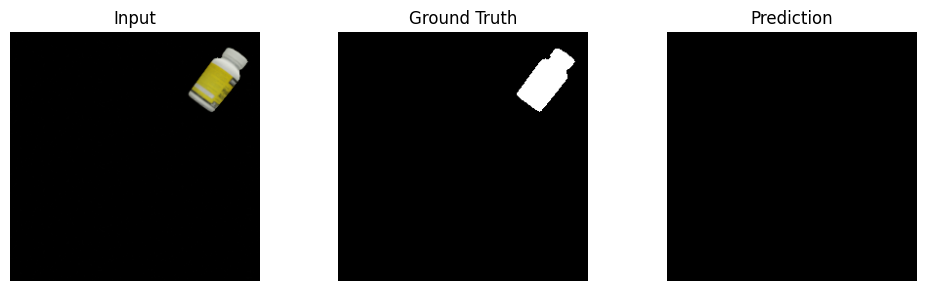

Evaluating middle frames:  91%|█████████ | 49/54 [00:12<00:01,  4.84it/s]

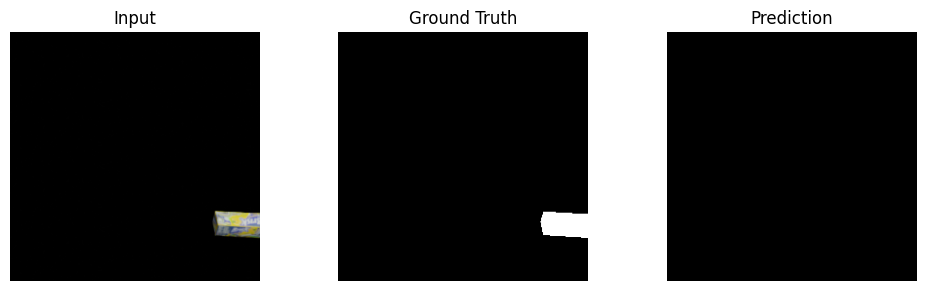

Evaluating middle frames:  93%|█████████▎| 50/54 [00:12<00:00,  4.87it/s]

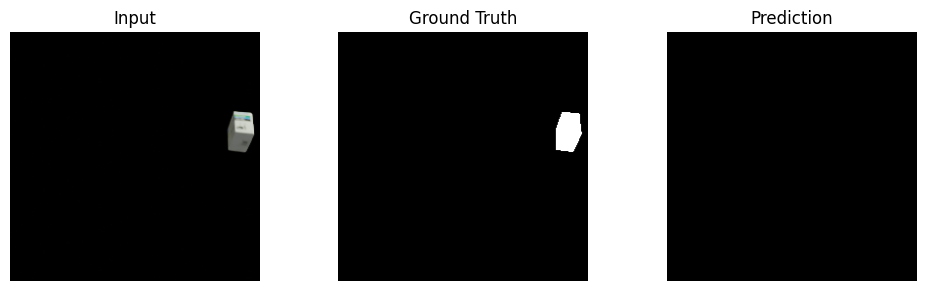

Evaluating middle frames:  94%|█████████▍| 51/54 [00:12<00:00,  4.96it/s]

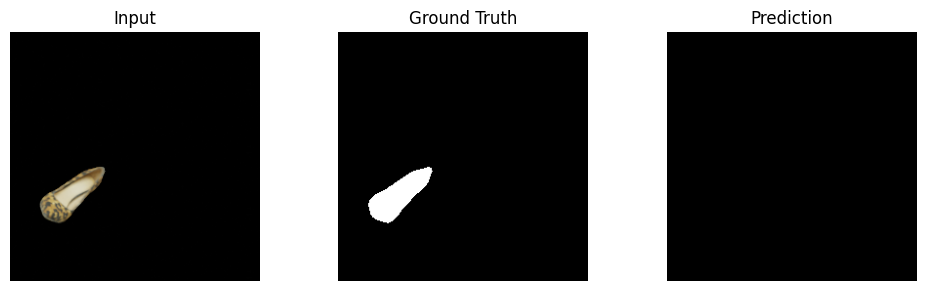

Evaluating middle frames:  96%|█████████▋| 52/54 [00:12<00:00,  4.94it/s]

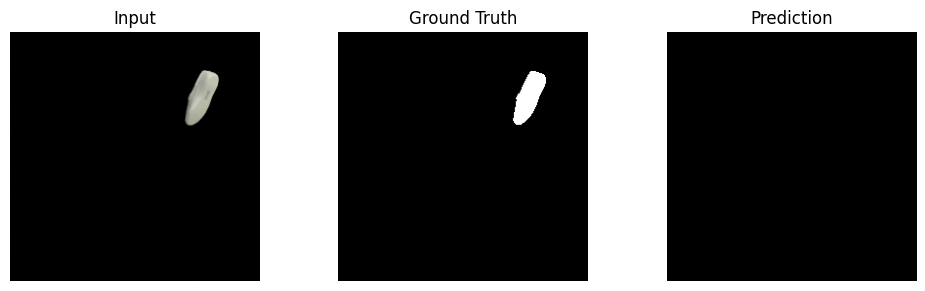

Evaluating middle frames:  98%|█████████▊| 53/54 [00:13<00:00,  4.95it/s]

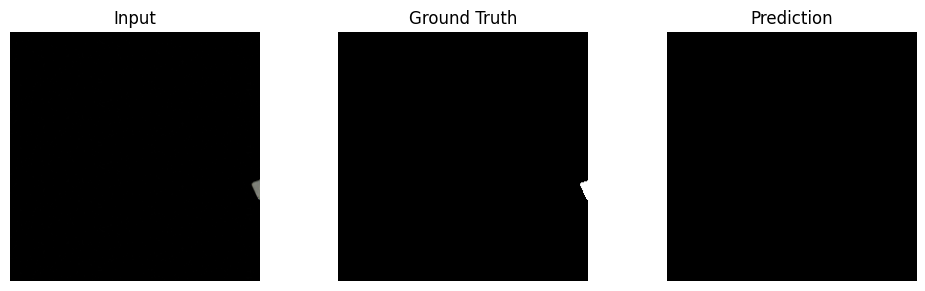

Evaluating middle frames: 100%|██████████| 54/54 [00:13<00:00,  4.06it/s]


In [10]:
from pathlib import Path
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define transform
transform_img = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
transform_mask = transforms.Resize((256, 256))

# Load U-Net (reuse model definition)
class UNet(torch.nn.Module):
    def __init__(self, in_channels=3, out_channels=2):
        super(UNet, self).__init__()
        def CBR(in_ch, out_ch):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_ch, out_ch, 3, padding=1),
                torch.nn.BatchNorm2d(out_ch),
                torch.nn.ReLU(inplace=True)
            )
        self.enc1 = torch.nn.Sequential(CBR(in_channels, 64), CBR(64, 64))
        self.enc2 = torch.nn.Sequential(CBR(64, 128), CBR(128, 128))
        self.enc3 = torch.nn.Sequential(CBR(128, 256), CBR(256, 256))
        self.pool = torch.nn.MaxPool2d(2)
        self.up1 = torch.nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = torch.nn.Sequential(CBR(256, 128), CBR(128, 128))
        self.up2 = torch.nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = torch.nn.Sequential(CBR(128, 64), CBR(64, 64))
        self.out = torch.nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        d1 = self.up1(e3)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)
        d2 = self.up2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)
        return self.out(d2)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=2).to(device)
# If you saved a model earlier, load it here:
# model.load_state_dict(torch.load("model.pth"))
model.eval()

# Root folder with objects
root_path = Path("/content/ff5da6d6ecae486bb294aeaf5ee8f8a1")

# Find all obj folders
obj_folders = sorted(root_path.rglob("obj_*"))

print(f"Found {len(obj_folders)} object folders.")

# Loop through each obj and test on middle frame
for obj_path in tqdm(obj_folders, desc="Evaluating middle frames"):
    rgba_files = sorted(obj_path.glob("rgba_*.png"))
    seg_files = sorted(obj_path.glob("segmentation_*.png"))

    if not rgba_files or not seg_files:
        continue

    # Get middle frame index
    mid = len(rgba_files) // 2
    rgba_path = rgba_files[mid]
    seg_path = seg_files[mid]

    # Load input and mask
    img = Image.open(rgba_path).convert("RGB")
    mask = Image.open(seg_path).convert("L")

    img_tensor = transform_img(img).unsqueeze(0).to(device)
    mask_tensor = transform_mask(mask)
    mask_tensor = torch.from_numpy(np.array(mask_tensor)).long()
    mask_tensor[mask_tensor > 0] = 1

    # Predict
    with torch.no_grad():
        pred = model(img_tensor)
        pred_mask = torch.argmax(pred.squeeze(), dim=0).cpu().numpy()

    # Show (optional: comment out if looping over many)
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Input")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask_tensor, cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Prediction")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
